# Visualize the Results of TCGA Classification using serially compression features

**Gregory Way, 2018**

Here I plot the analysis of predicting mutations and cancer-types in TCGA PanCanAtlas using an elastic net logistic regression model.

We make predictions using features derived across z dimensions, algorithms, and different initializations.
For more details on the methods refer to [Way et al. 2018](https://doi.org/10.1016/j.celrep.2018.03.046).

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(readr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(ggrepel))

source(file.path("scripts", "viz_util.R"))

In [2]:
# Load all cancertype classification results
cancertype_path <- file.path("results", "cancer-type")
full_cancertype_df <- load_results(results_path = cancertype_path, process_output = TRUE)

In [3]:
# Load all mutation classification results
mut_path <- file.path("results", "mutation")
full_mutation_df <- load_results(results_path = mut_path)

full_raw_mutation_df <- full_mutation_df[['raw_metrics']]
full_mutation_df <- load_results(results_path = mut_path, process_output = TRUE)

## Plot Supplementary Figure

In [4]:
# Setup plotting logic for supplmental plots
cancertypes <- as.character(unique(full_cancertype_df$gene_or_cancertype))
genes <- unique(levels(full_mutation_df$gene_or_cancertype))

In [5]:
# Create cancertype plots
gg_list <- list()

n_cancertype_plots <- 33
n_cancertype_plots_per_page <- 11

for (plot_idx in seq(1, n_cancertype_plots, n_cancertype_plots_per_page)) {
    end_idx <- plot_idx + n_cancertype_plots_per_page - 1
    use_cancertypes <- cancertypes[plot_idx:end_idx]
    
    subset_df <- full_cancertype_df %>%
        dplyr::filter(gene_or_cancertype %in% use_cancertypes)
    subset_df$gene_or_cancertype <- as.character(subset_df$gene_or_cancertype)
    
    gg_list[[use_cancertypes[1]]] <- plot_mutation_figure(df = subset_df)
}

In [6]:
# Create mutation plots (append to existing gglist)
n_top_mutations <- 50
n_plots_per_page <- 10

for (plot_idx in seq(1, n_top_mutations, n_plots_per_page)) {
    end_idx <- plot_idx + n_plots_per_page - 1
    use_genes <- genes[plot_idx:end_idx]
    
    subset_df <- full_mutation_df %>%
        dplyr::filter(gene_or_cancertype %in% use_genes)
    
    gg_list[[use_genes[1]]] <- plot_mutation_figure(df = subset_df)
}

In [7]:
# Save a series of plots
sup_fig_height = 150
sup_fig_width = 170 

for (plot_idx in 1:length(gg_list)) {
    
    # Extract index name of list
    plot_name <- names(gg_list)[plot_idx]
    
    # Put legend on the bottom
    g <- gg_list[[plot_name]] + theme(legend.position = "bottom")

    # Save Figure
    for (extension in c(".png", ".pdf")) {

        # Save figure with the index and name of the plot - will present in this
        # order in the supplementary figure
        fig_file <- paste0("supplementary_figure_tcga_classify_auroc_plotindex_",
                           plot_idx,
                           "_name_",
                           plot_name,
                           extension)
        
        fig_file <- file.path("figures", fig_file)
        
        ggplot2::ggsave(filename = fig_file,
                        plot = g,
                        height = sup_fig_height,
                        width = sup_fig_width,
                        units = "mm")
    }
}

## Plot Main Figure

In [8]:
classifier_base_theme <-
    theme(strip.background = element_rect(colour = "black", fill = "#fdfff4"),
          strip.text = element_text(size = 7),
          axis.title = element_text(size = 8),
          axis.text.x = element_blank(),
          axis.text.y = element_text(size = 6),
          legend.position = "bottom",
          legend.title = element_text(size = 8),
          legend.text = element_text(size = 7),
          legend.margin = margin(t = 0, r = 0, b = 0, l = 0),
          legend.box.margin = margin(t = -3, r = 0, b = -3, l = -3))

### Panel A - Select Cancer-Types AUC across dimensions and algorithms

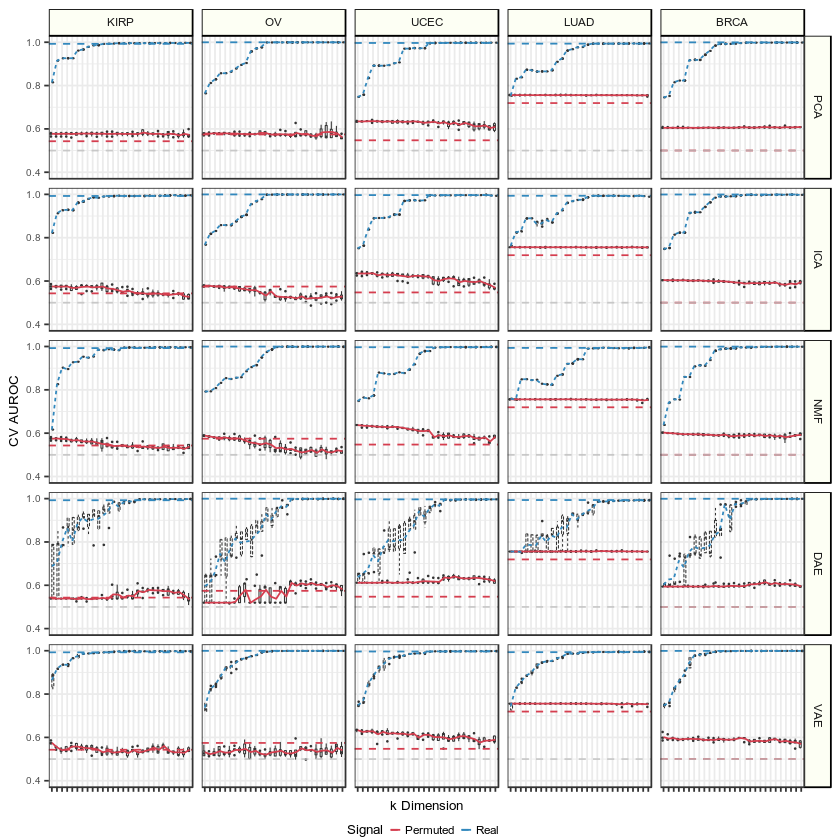

In [9]:
focus_cancertypes <- c("KIRP", "OV", "UCEC", "LUAD", "BRCA")

focus_cancertype_df <- full_cancertype_df %>%
  dplyr::filter(gene_or_cancertype %in% focus_cancertypes) %>%
  dplyr::mutate(gene_or_cancertype =
                  factor(gene_or_cancertype, levels = focus_cancertypes))

panel_a_gg <- plot_mutation_figure(df = focus_cancertype_df)
panel_a_gg <- panel_a_gg +
    classifier_base_theme +
    ylab("CV AUROC") +
    guides(color = guide_legend(keywidth = 0.1,
                                keyheight = 0.1,
                                default.unit = "inch"))

panel_a_gg

### Panel B - Select mutations AUC across dimensions and algorithms

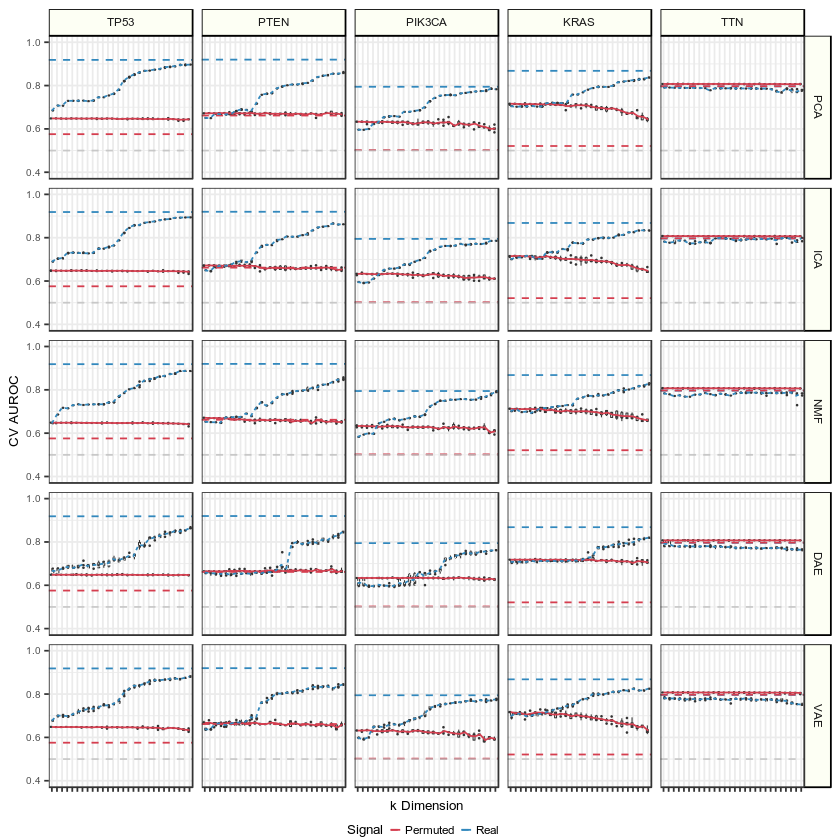

In [10]:
focus_genes <- c("TP53", "PTEN", "PIK3CA", "KRAS", "TTN")

focus_mut_df <- full_mutation_df %>%
  dplyr::filter(gene_or_cancertype %in% focus_genes) %>%
  dplyr::mutate(gene_or_cancertype =
                  factor(gene_or_cancertype, levels = focus_genes))

panel_b_gg <- plot_mutation_figure(df = focus_mut_df)

panel_b_gg <- panel_b_gg +
    classifier_base_theme +
    ylab("CV AUROC") +
    guides(color = guide_legend(keywidth = 0.1,
                                keyheight = 0.1,
                                default.unit = "inch"))

panel_b_gg

### Panel C - Sparsity of Select Models

In [11]:
# Load Results
full_coef_results <- load_results(results_path = mut_path,
                                  file_string = "coefficients")

In [12]:
coef_df <- full_coef_results[["metrics"]]
raw_coef_df <- full_coef_results[["raw_metrics"]]

In [13]:
sparsity_metric_df <- process_sparsity(coef_df = coef_df,
                                       mut_df = full_mutation_df,
                                       focus_genes = focus_genes)

raw_sparsity_metric_df <- process_sparsity(coef_df = raw_coef_df,
                                           mut_df = full_raw_mutation_df,
                                           focus_genes = focus_genes)

Warning message:
“Column `gene`/`gene_or_cancertype` joining character vector and factor, coercing into character vector”

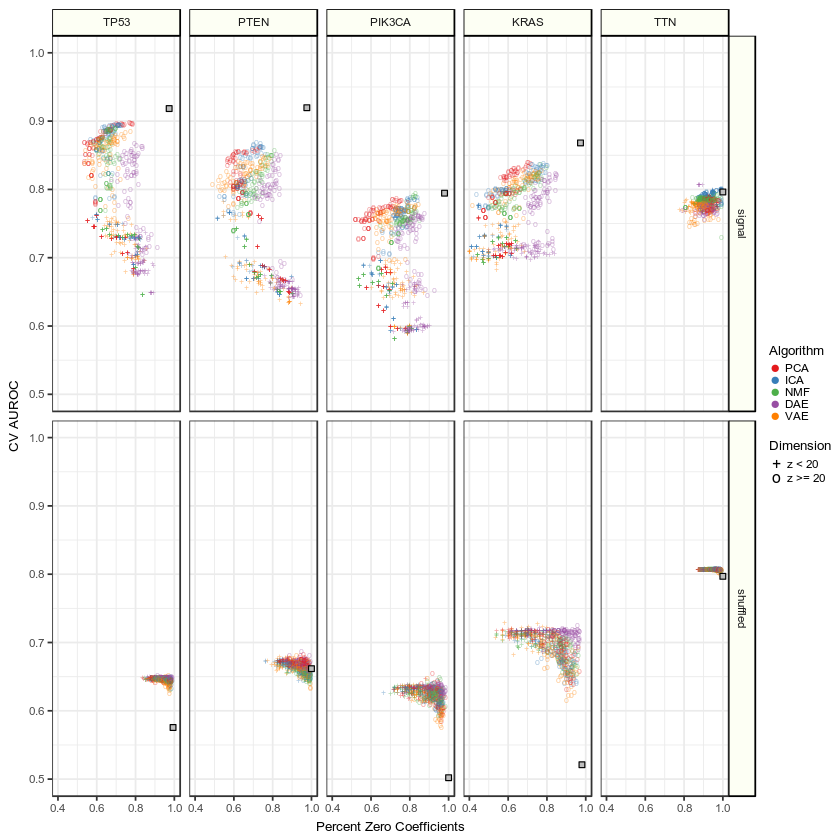

In [14]:
panel_c_gg <- ggplot(sparsity_metric_df,
                     aes(x = percent_zero,
                         y = auroc)) +
  geom_point(aes(color = algorithm,
                 shape = z_dim_shape),
             alpha = 0.4) +
  geom_point(data = raw_sparsity_metric_df,
             aes(x = percent_zero,
                 y = auroc),
             color = "black",
             fill = "grey",
             pch = 22) +
  scale_color_manual(name = "Algorithm",
                     values = c("#e41a1c",
                                "#377eb8",
                                "#4daf4a",
                                "#984ea3",
                                "#ff7f00"),
                     labels = c("pca" = "PCA",
                                "ica" = "ICA",
                                "nmf" = "NMF",
                                "dae" = "DAE",
                                "vae" = "VAE")) +
  scale_shape_manual(values = c("+", "o")) +
  ylim(c(0.5, 1)) +
  ylab("CV AUROC") +
  xlab("Percent Zero Coefficients") + 
  facet_grid(signal ~ gene) +
  theme_bw() +
  theme(strip.background = element_rect(colour = "black", fill = "#fdfff4"),
        strip.text = element_text(size = 7),
        axis.title = element_text(size = 8),
        axis.text.x = element_text(size = 7),
        axis.text.y = element_text(size = 7),
        legend.position = "right",
        legend.title = element_text(size = 8),
        legend.text = element_text(size = 7),
        legend.margin = margin(t = 0, r = 0, b = 0, l = 0),
        legend.box.margin = margin(t = -3, r = 0, b = -3, l = -3)) +
  guides(color = guide_legend(order = 1,
                              keywidth = 0.1,
                              keyheight = 0.1,
                              default.unit = "inch",
                              override.aes = list(size = 1.4,
                                                  alpha = 1)),
         shape = guide_legend(order = 2,
                              keywidth = 0.1,
                              keyheight = 0.1,
                              default.unit = "inch",
                              title = "Dimension",
                              override.aes = list(size = 3,
                                                  alpha = 1)))

panel_c_gg

### Panel D - Determining which features have highest importance in classification

In [15]:
# Find Model with High Sparsity and High Performance
top_gene <- "TP53"
top_feature_search_df <- sparsity_metric_df %>%
  dplyr::filter(algorithm == 'DAE',
                gene == top_gene,
                auroc > 0.75,
                percent_zero > 0.8) %>% 
  dplyr::top_n(1, auroc)

outfile <- file.path("results", "top_dae_tp53_feature_for_followup.tsv")
readr::write_tsv(top_feature_search_df, outfile)

top_feature_search_df

gene,signal,z_dim,seed,algorithm,weight,num_features,percent_zero,auroc,aupr,data_type,grouping_,auroc_raw,aupr_raw,z_dim_shape
TP53,signal,200,908341,DAE,179,222,0.8063063,0.86364,0.82745,cv,TP53signal,0.91836,0.88467,z >= 20


In [16]:
# What feature is most explanatory in this model?
top_tp53_features <- coef_df %>%
    dplyr::filter(z_dim == top_feature_search_df$z_dim,
                  seed == top_feature_search_df$seed,
                  algorithm == 'DAE',
                  gene == "TP53",
                  signal == 'signal') %>%
    dplyr::arrange(weight)

top_tp53_features$ranked <- 1:nrow(top_tp53_features)

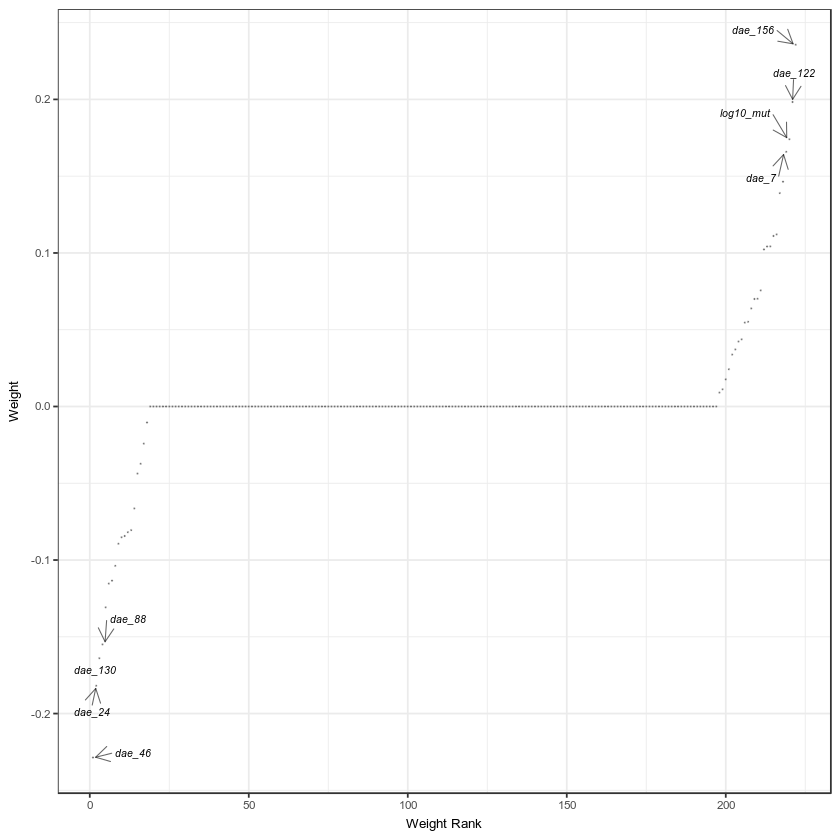

In [17]:
panel_d_gg <- ggplot(top_tp53_features,
                     aes(x = ranked, y = weight)) +
  geom_point(alpha = 0.3,
             size = 0.02) +
  xlab("Weight Rank") +
  ylab("Weight") +
  geom_text_repel(data = subset(top_tp53_features,
                                (weight > 0.15 | weight < -0.14)),
                  arrow = arrow(length = unit(0.02, 'npc')),
                  segment.size = 0.3,
                  segment.alpha = 0.6,
                  box.padding = 0.68,
                  point.padding = 0.22,
                  size = 2.2,
                  fontface = 'italic',
                  aes(x = ranked, y = weight, label = feature)) +
  theme_bw() +
  theme(axis.title = element_text(size = 8),
        axis.text.x = element_text(size = 7),
        axis.text.y = element_text(size = 7))

panel_d_gg

### Panel E - ROC Curve of Sparse Model Predicting TP53

In [18]:
metric_col_type <- readr::cols(
    .default = readr::col_double(),
    predictor = readr::col_character(),
    signal = readr::col_character(),
    z_dim = readr::col_integer(),
    seed = readr::col_integer(),
    algorithm = readr::col_character(),
    data_type = readr::col_character()
)

In [19]:
# Find metrics for the specific model
top_model_path <- file.path("results", "mutation", top_gene)

auc_file <- file.path(top_model_path, paste0(top_gene, "_auc_threshold_metrics.tsv.gz"))

roc_df <- readr::read_tsv(auc_file,
                          col_types = metric_col_type) %>%
  dplyr::filter(z_dim == top_feature_search_df$z_dim,
                seed == top_feature_search_df$seed,
                algorithm == 'dae')

aupr_file <- file.path(top_model_path, paste0(top_gene, "_aupr_threshold_metrics.tsv.gz"))

pr_df <- readr::read_tsv(aupr_file,
                         col_types = metric_col_type) %>%
  dplyr::filter(z_dim == top_feature_search_df$z_dim,
                seed == top_feature_search_df$seed,
                algorithm == 'dae')

In [20]:
# Load Raw metrics
auc_raw_file <- file.path(top_model_path,
                          paste0(top_gene, "_raw_auc_threshold_metrics.tsv.gz"))
roc_raw_df <- readr::read_tsv(auc_raw_file, col_types = metric_col_type) 

aupr_raw_file <- file.path(top_model_path,
                           paste0(top_gene, "_raw_aupr_threshold_metrics.tsv.gz"))
pr_raw_df <- readr::read_tsv(aupr_raw_file, col_types = metric_col_type)

full_roc_df <- dplyr::bind_rows(roc_df, roc_raw_df)
full_roc_df$model_groups <- paste(full_roc_df$algorithm, full_roc_df$data_type)

full_pr_df <- dplyr::bind_rows(pr_df, pr_raw_df)
full_pr_df$model_groups <- paste(full_pr_df$algorithm, full_pr_df$data_type)

In [21]:
# Setup plotting variables
curve_colors <- c("#1b9e77",
                  "#d95f02",
                  "#7570b3",
                  "#737373",
                  "#bdbdbd",
                  "#d9d9d9")

curve_labels <- c("dae cv" = "DAE CV",
                  "dae test" = "DAE Test",
                  "dae train" = "DAE Train",
                  "raw cv" = "Raw CV",
                  "raw test" = "Raw Test",
                  "raw train" = "Raw Train")

curve_base_theme <-
    theme(axis.title = element_text(size = 8),
          axis.text.x = element_text(size = 7),
          axis.text.y = element_text(size = 7),
          legend.title = element_text(size = 8),
          legend.text = element_text(size = 7),
          legend.margin = margin(t = 0, r = 0, b = 0, l = 0),
          legend.box.margin = margin(t = -3, r = 0, b = -3, l = -3))

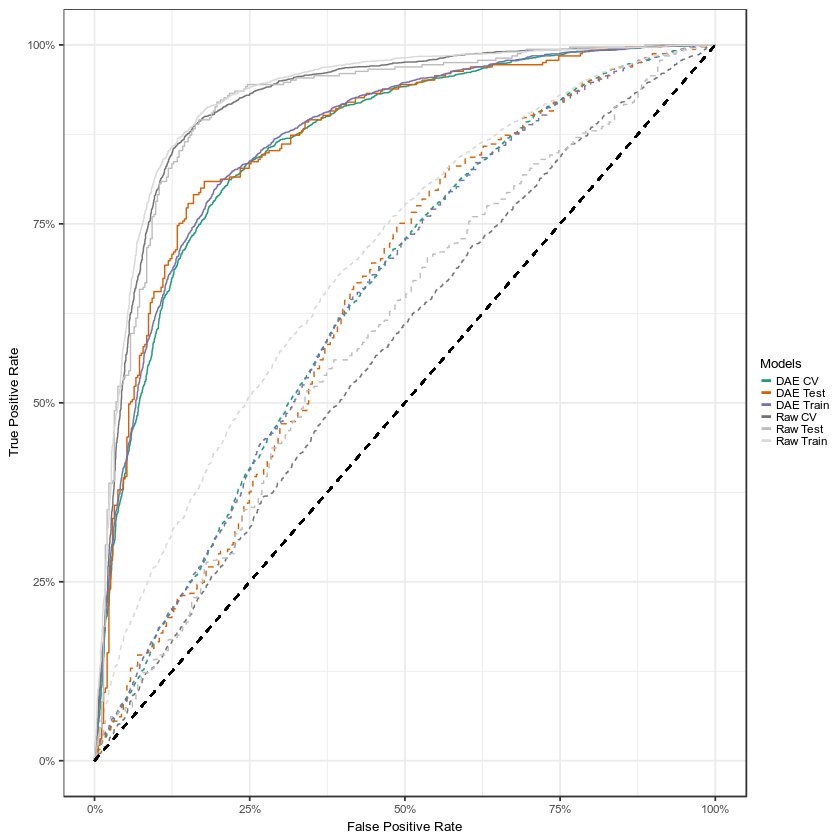

In [22]:
panel_e_gg <- ggplot(full_roc_df,
                     aes(x = fpr,
                         y = tpr,
                         color = model_groups)) +
  geom_step(aes(linetype = signal), size = 0.4) +
  geom_segment(aes(x = 0,
                   y = 0,
                   xend = 1,
                   yend = 1),
               linetype = "dashed",
               color = "black") +
  scale_y_continuous(labels = scales::percent) +
  scale_x_continuous(labels = scales::percent) +
  scale_color_manual(name = "Models",
                     values = curve_colors,
                     labels = curve_labels) +
  scale_linetype_manual(name = "Data",
                        values = c("dashed",
                                   "solid"),
                     labels = c("signal" = "Signal",
                                "shuffled" = "Shuffled")) +
  xlab("False Positive Rate") +
  ylab("True Positive Rate") +
  theme_bw() +
  curve_base_theme +
  guides(color = guide_legend(order = 1,
                              keywidth = 0.1,
                              keyheight = 0.1,
                              default.unit = "inch",
                              override.aes = list(size = 0.8)),
         linetype = FALSE)


panel_e_gg

### Panel F - Precision Recall Curve of Sparse Model Predicting TP53

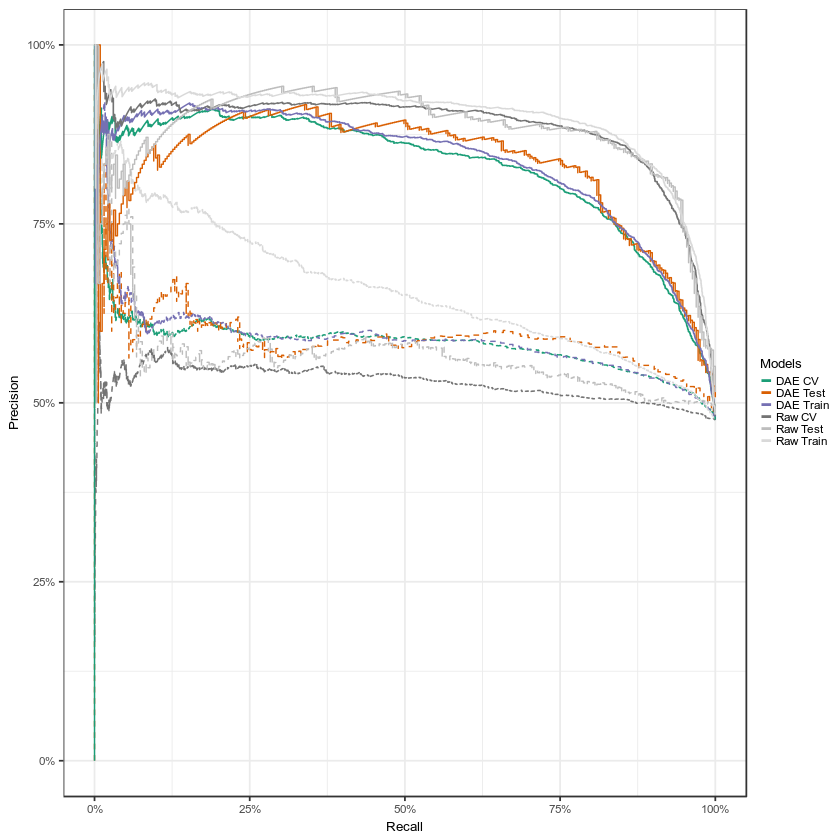

In [23]:
panel_f_gg <- ggplot(full_pr_df,
                     aes(x = recall,
                         y = precision,
                         color = model_groups)) +
  geom_step(aes(linetype = signal), size = 0.4) +
  scale_y_continuous(labels = scales::percent) +
  scale_x_continuous(labels = scales::percent) +
  scale_color_manual(name = "Models",
                     values = curve_colors,
                     labels = curve_labels) +
  scale_linetype_manual(name = "Data",
                        values = c("dashed",
                                   "solid"),
                        labels = c("signal" = "Signal",
                                   "shuffled" = "Shuffled")) +
  xlab("Recall") +
  ylab("Precision") +
  theme_bw() +
  curve_base_theme +
  guides(color = guide_legend(order = 1,
                              keywidth = 0.1,
                              keyheight = 0.1,
                              default.unit = "inch",
                              override.aes = list(size = 0.8)),
         linetype = FALSE)

panel_f_gg

# Compile Full Main Figure

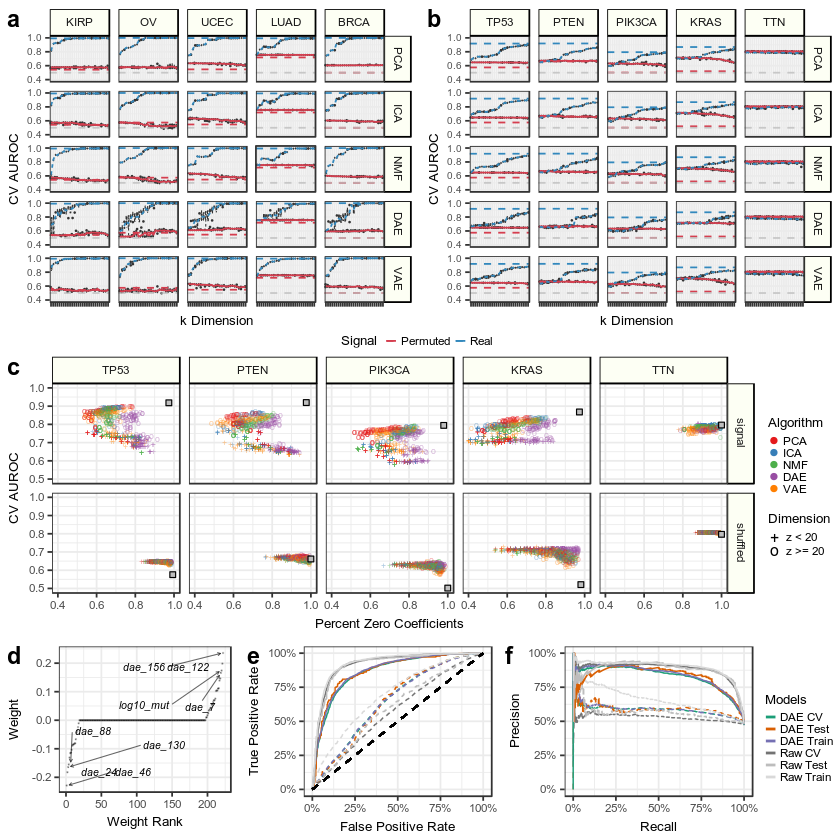

In [24]:
a_and_b_legend_gg <- cowplot::get_legend(panel_a_gg)

a_and_b_gg <- cowplot::plot_grid(
    panel_a_gg + theme(legend.position = "none"),
    panel_b_gg + theme(legend.position = "none"),
    rel_widths = c(1, 1),
    labels = c("a", "b"),
    ncol = 2
)

a_and_b_gg <- cowplot::plot_grid(
    a_and_b_gg,
    a_and_b_legend_gg,
    rel_heights = c(1, 0.04),
    nrow = 2
)

e_and_f_legend_gg <- cowplot::get_legend(panel_e_gg)

e_and_f_gg <- cowplot::plot_grid(
    panel_e_gg + theme(legend.position = "none"),
    panel_f_gg + theme(legend.position = "none"),
    rel_widths = c(1, 1),
    labels = c("e", "f"),
    ncol = 2,
    nrow = 1
)

e_and_f_gg <- cowplot::plot_grid(
    e_and_f_gg,
    e_and_f_legend_gg,
    rel_widths = c(1, 0.15),
    ncol = 2
)

d_e_and_f_gg <- cowplot::plot_grid(
    panel_d_gg,
    e_and_f_gg,
    rel_widths = c(0.4, 1),
    labels = c("d", ""),
    ncol = 2
)

full_gg <- cowplot::plot_grid(
    a_and_b_gg,
    panel_c_gg,
    d_e_and_f_gg,
    nrow = 3,
    labels = c("", "c", ""),
    rel_heights = c(1.2, 1, 0.7)
)

full_gg

In [25]:
for(extension in c('.png', '.pdf')) {
    gg_file <- paste0("tcga_biobombe_main_figure", extension)
    gg_file <- file.path("figures", gg_file)
    cowplot::save_plot(filename = gg_file,
                       plot = full_gg,
                       dpi = 300,
                       base_height = 190,
                       base_width = 170,
                       units = "mm")
}